<a href="https://colab.research.google.com/github/andvar95/Inteligencia-Artificial/blob/main/Ejemplo_Transfer_Learning_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf test
!rm -rf train

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import zipfile
#optional
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Este tutorial usa imágenes de gatos y perros.
Se descarga y extra el archivo ZIP, Se crea un *tf.data.Dataset* para entrenamiento y validación usando *image_dataset_from_directory*


In [ ]:
with zipfile.ZipFile("/content/drive/My Drive/Proyecto_CalculosRenales/Imagenes/ML/patches/patches_3c_adriana.zip","r") as file:
  file.extractall(".") 

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (160,160)

train_dataset = image_dataset_from_directory("/content/train",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
'''
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
                                             '''

Found 1171 files belonging to 3 classes.


'\nvalidation_dataset = image_dataset_from_directory(validation_dir,\n                                             shuffle=True,\n                                             batch_size=BATCH_SIZE,\n                                             image_size=IMG_SIZE)\n                                             '

Se muestran las primeras nueve imágenes del dataset

**take** = Return the elements in the given positional indices along an axis.


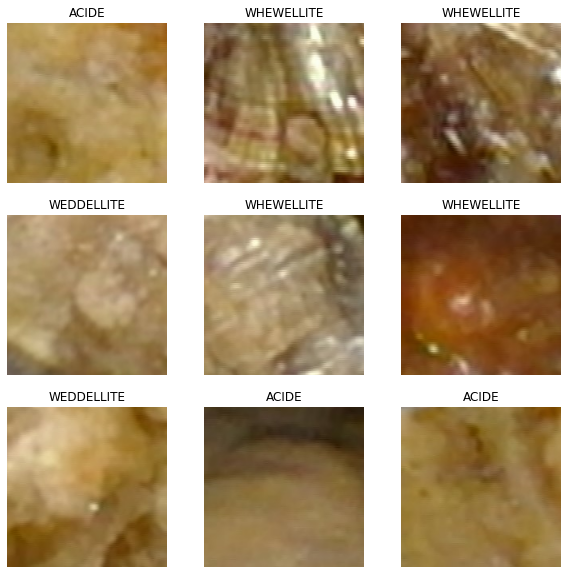

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


No hay un cojunto de prueba por tanto se crea.
Se determina cuantos lotes están disponibles en los datos de validación usando tf.data.experimental.cardinality y el 20% se mueve al conjunto de prueba (test).

**tf.data.experimental.cardinality** : Returns the cardinality of dataset (number of elements)



Configurar para rendimiento

Se usa la captación anterior por búfer para cargar imágenes desde el disco sin que se bloquee la E/S. 

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Se aumenta los datos, ya que se tienen pocos datos por lo que se aplican diversidad artíficial  aplicando a las imágenes efectos como rotación y volteo horizontal.

Se prueba en imágenes

El modelo a usar es MobilenetV2 este espera datos entre [-1,1] pero se estos están entre [0,255]

In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

Se crea el modelo MobileNetV2 y se debe elegir que capas usará. Dónde la última capa de clasificación no es muy útil. Es común usar usar la ultima capa antes de aplanar "Capa cuello botella" esta conversa más generalidad que la capa final/superior

Se crea la instancia de MobileNet con sus pesos. el argumento **include_top=False** omite las capas superiores. 

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model =  tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                 include_top= False,
                                                 weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


El extractor de características convierte las imágenes 160x160x3 en una bloque de características d 5x5x1280

In [ ]:
image_batch,label_batch =next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 512)


Se congela la base convolucional  o se puede entrenar de igual forma


In [ ]:
base_model.trainable = True



In [ ]:
#We'll see how many layers there's in base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards - All layers as trainable
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False



Number of layers in the base model:  19


Muchas modelos tiene capas tf.kera.layer.BatchNormalization. Esta capa es una caso especial a observar en el ajust fino

Cuando se establece layers.trainable = False, la capa BatchNormalization  se ejecuta en modo inferencia y no actualiza la media o varianza

Cuando descongela un modelo que contiene capas de BatchNormalization para realizar un ajuste fino, debe mantener las capas de BatchNormalization en modo de inferencia pasando training = False al llamar al modelo base. De lo contrario, las actualizaciones aplicadas a los pesos no entrenables destruirán lo que ha aprendido el modelo.

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

Para generar predicciones a partir del bloque de tf.keras.layers.GlobalAveragePooling2D , tf.keras.layers.GlobalAveragePooling2D las ubicaciones espaciales espaciales de 5x5 , utilizando una capa tf.keras.layers.GlobalAveragePooling2D para convertir las tf.keras.layers.GlobalAveragePooling2D en un solo vector de 1280 elementos por imagen.

In [ ]:
global_average_layer =tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 512)


Aplique una capa tf.keras.layers.Dense para convertir estas características en una única predicción por imagen. No necesita una función de activación aquí porque esta predicción se tratará como un logit o un valor de predicción sin procesar. Los números positivos predicen la clase 1, los números negativos predicen la clase 0.

Se concatenan las capas de aumento de datos, cambio de escala, base mode y extractor de características

In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))
#x=data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x,training=False)
x= global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
#outputs = prediction_layer(x)
model = tf.keras.Model(inputs,x)


Compile el modelo antes de entrenarlo. Dado que hay dos clases, use una pérdida de entropía cruzada binaria con from_logits=True ya que el modelo proporciona una salida lineal.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate)
              )
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
__________________________________________

In [ ]:
fine_tune_epochs = 10
total_epochs =   fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs)

Epoch 1/10
19/19 [==============================] - 9s 452ms/step - loss: 3.7295 - accuracy: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 7s 386ms/step - loss: 2.3221 - accuracy: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 7s 388ms/step - loss: 2.0429 - accuracy: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 7s 393ms/step - loss: 1.8311 - accuracy: 0.0000e+00
Epoch 5/10
19/19 [==============================] - 8s 397ms/step - loss: 1.5534 - accuracy: 0.0000e+00
Epoch 6/10
19/19 [==============================] - 8s 401ms/step - loss: 1.4394 - accuracy: 0.0000e+00
Epoch 7/10
19/19 [==============================] - 8s 403ms/step - loss: 1.2223 - accuracy: 0.0000e+00
Epoch 8/10
19/19 [==============================] - 8s 409ms/step - loss: 1.0345 - accuracy: 0.0000e+00
Epoch 9/10
19/19 [==============================] - 8s 413ms/step - loss: 1.0683 - accuracy: 0.0000e+00
Epoch 10/10
19/19 [==============================] - 8s 419ms/st

In [ ]:
Features = np.empty((256,160,160,3))
Labels = np.empty((1))

for batch in train_dataset:
  image_batch,label_batch =next(iter(train_dataset))
  Features = np.concatenate((Features ,image_batch),axis=0)
  Labels = np.concatenate((Labels, label_batch),axis=0)
print(Labels)

#Out_Data_a = np.array(Out_data)
#print(Out_data.shape)

[0. 1. 2. ... 2. 0. 2.]


In [ ]:
from random import randint
clases = range(int(max(Labels)+1)) 
idx = []
c_clases = [0]*len(clases)
maximo = 5
Features_ = np.empty((0,Features.shape[1],Features.shape[2],Features.shape[3]))
print(maximo*len(clases))
Labels_ = []


while True:

  pos = randint(0,len(Labels))
  if pos not in idx:
    if c_clases[int(Labels[pos])]<maximo:
      idx.append(pos)
      It_data = np.reshape(Features[pos],(1,160,160,3))
      Features_ = np.concatenate((Features_ ,It_data),axis=0)
      Labels_.append(Labels[pos])
      c_clases[int(Labels[pos])] += 1
  print(c_clases)
  if maximo*len(clases) == sum(c_clases):
    break


15
[1, 0, 0]
[1, 0, 1]
[1, 0, 2]
[1, 0, 3]
[1, 0, 4]
[2, 0, 4]
[2, 0, 5]
[2, 0, 5]
[2, 1, 5]
[2, 1, 5]
[2, 1, 5]
[2, 1, 5]
[2, 2, 5]
[2, 3, 5]
[2, 3, 5]
[2, 3, 5]
[2, 3, 5]
[2, 3, 5]
[2, 3, 5]
[3, 3, 5]
[4, 3, 5]
[5, 3, 5]
[5, 3, 5]
[5, 3, 5]
[5, 4, 5]
[5, 4, 5]
[5, 5, 5]


In [ ]:
Antes_Clasificador = model.predict(Features_)

In [ ]:
from sklearn.manifold import TSNE

tnse = TSNE(n_components=3, random_state=0, perplexity=100).fit_transform(Antes_Clasificador)


In [ ]:
Labels_ = np.array(Labels_)
target_ids = range(len(class_names))
print(Labels_.shape)


(15,)


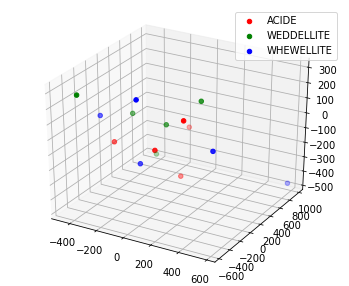

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111,projection='3d')
colors = 'r', 'g','b','c','m','y'
for i, c, label in zip(target_ids, colors, class_names):
    ax.scatter(tnse[Labels_ == i, 0], tnse[Labels_ == i, 1],tnse[Labels_ == i, 2], c=c, label=label)
plt.legend()
plt.show()